<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.8/Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization

- learning rate과 weight decay를 bayesian optimization함

- lstm 사용

- dataset : Amazon 주식 dataset (AMZN.csv)

In [4]:
!pip install bayesian-optimization
  
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import datetime

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import random

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


[1] Data processing

In [7]:
# 파일 불러오기
train_data_url = "/content/drive/MyDrive/DL 실습/AMZN.csv"
df = pd.read_csv(train_data_url)
print (df.shape) # 파일 형식 확인
df

(5178, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
5173,2017-12-04,1173.849976,1175.199951,1128.000000,1133.949951,1133.949951,5931900
5174,2017-12-05,1128.260010,1159.270020,1124.739990,1141.569946,1141.569946,4079800
5175,2017-12-06,1137.989990,1155.890015,1136.079956,1152.349976,1152.349976,2853300
5176,2017-12-07,1156.589966,1163.189941,1151.000000,1159.790039,1159.790039,2508800


In [8]:
# 필요없는 항목(Volume : 거래량) 제거
X = df.drop(columns = ['Volume','Date'])
# y값은 Adj Close 로 지정 ( 종가 )
y = df.iloc[:, 5:6]

print (X)
print (y)

             Open         High          Low        Close    Adj Close
0        2.437500     2.500000     1.927083     1.958333     1.958333
1        1.968750     1.979167     1.708333     1.729167     1.729167
2        1.760417     1.770833     1.625000     1.708333     1.708333
3        1.729167     1.750000     1.635417     1.635417     1.635417
4        1.635417     1.645833     1.375000     1.427083     1.427083
...           ...          ...          ...          ...          ...
5173  1173.849976  1175.199951  1128.000000  1133.949951  1133.949951
5174  1128.260010  1159.270020  1124.739990  1141.569946  1141.569946
5175  1137.989990  1155.890015  1136.079956  1152.349976  1152.349976
5176  1156.589966  1163.189941  1151.000000  1159.790039  1159.790039
5177  1170.400024  1172.750000  1157.099976  1162.000000  1162.000000

[5178 rows x 5 columns]
        Adj Close
0        1.958333
1        1.729167
2        1.708333
3        1.635417
4        1.427083
...           ...
5173  113

In [9]:
scaler = StandardScaler()
scaler.fit(X)
scaler.fit(y)
X_scale = scaler.fit_transform(X)
y_scale = scaler.fit_transform(y)

# train, test data set 나누기
x_train, x_test, y_train, y_test = train_test_split(X_scale, y_scale, test_size = 0.3, shuffle = True, random_state = 1234)

# train set
print("x_train의 크기: ",x_train.shape)
print("y_train의 크기: ",y_train.shape)

# test set
print("x_test의 크기: ",x_test.shape)
print("y_test의 크기: ",y_test.shape)

# data 텐서로 변환
x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

X_train_tensors_final = torch.reshape(x_train_tensor,   
                        (x_train_tensor.shape[0], 1, x_train_tensor.shape[1]))
X_test_tensors_final = torch.reshape(x_test_tensor,  
                        (x_test_tensor.shape[0], 1, x_test_tensor.shape[1])) 

# train set
print("x_train_shape: ",x_train_tensor.shape)
print("y_train_shape:: ",y_train_tensor.shape)

# test set
print("x_test_shape: ",x_test_tensor.shape)
print("y_test_shape: ",y_test_tensor.shape)

x_train의 크기:  (3624, 5)
y_train의 크기:  (3624, 1)
x_test의 크기:  (1554, 5)
y_test의 크기:  (1554, 1)
x_train_shape:  torch.Size([3624, 5])
y_train_shape::  torch.Size([3624, 1])
x_test_shape:  torch.Size([1554, 5])
y_test_shape:  torch.Size([1554, 1])


[2] Model

In [10]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                         num_layers = num_layers, batch_first = True)
    self.layer1 = nn.Linear(hidden_size, 256)
    self.layer2 = nn.Linear(256, 256)
    self.layer3 = nn.Linear(256, 128)
    self.layer_out = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # hidden state
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # internal process state
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    output, (hn, cn) = self.lstm(x, (h_0, c_0))

    # Data reshaping
    hn = hn.view(-1, self.hidden_size)

    out = self.relu(hn)
    out = self.layer1(out)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)
    out = self.relu(out)
    out = self.layer_out(out)

    return out

In [19]:
# set parameter

num_epoch = 50
learning_rate = 0.01
weight_decay = 1e-5

input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensor.shape[1])
loss_function = torch.nn.MSELoss() 


In [25]:
def train_acc(lr, wd):

    loss_list = []
    learning_rate = lr
    weight_decay = wd
    
    optimizer = optim.Adam(lstm.parameters(), lr = learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epoch):
      outputs = lstm.forward(X_train_tensors_final.to(device))
      optimizer.zero_grad()

      loss = loss_function(outputs, y_train_tensor.to(device))
      loss_list.append(loss.detach().numpy())
      loss.backward()

      optimizer.step()


    return loss.detach().numpy()
# loss를 기준으로 hyperparameter 찾도록 함

In [26]:
from bayes_opt import BayesianOptimization

pbounds = {'lr':(0,1),  'wd':(0,1)} # 하이퍼파라미터 범위 설정
optimizer = BayesianOptimization( f=train_acc, pbounds= pbounds, random_state=1 )

optimizer.maximize( init_points= 5, n_iter=45 )

|   iter    |  target   |    lr     |    wd     |
-------------------------------------------------
|  1        |  120.6    |  0.417    |  0.7203   |
|  2        |  0.539    |  0.000114 |  0.3023   |
|  3        |  0.5924   |  0.1468   |  0.09234  |
|  4        |  0.3706   |  0.1863   |  0.3456   |
|  5        |  7.08     |  0.3968   |  0.5388   |
|  6        |  0.5655   |  0.1088   |  0.3689   |
|  7        |  1.654    |  0.4295   |  0.8212   |
|  8        |  5.841    |  0.1493   |  0.6288   |
|  9        |  12.86    |  0.4152   |  0.7072   |
|  10       |  315.2    |  0.3956   |  0.1615   |
|  11       |  87.31    |  0.8877   |  0.4472   |
|  12       |  15.22    |  0.4323   |  0.352    |
|  13       |  18.74    |  0.6099   |  0.3929   |
|  14       |  14.56    |  0.5532   |  0.702    |
|  15       |  4.917    |  0.1484   |  0.4067   |
|  16       |  0.2254   |  0.06681  |  0.5343   |
|  17       |  33.36    |  0.3392   |  0.2749   |
|  18       |  0.2067   |  0.1909   |  0.6735   |


In [27]:
print( optimizer.max )

{'target': 2820995.5, 'params': {'lr': 0.9111313637898341, 'wd': 0.41757886369625574}}


In [29]:
# hyperparmeter로 학습
learning_rate =  0.9111313637898341
weight_decay =  0.41757886369625574
num_epoch = 1000
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensor.shape[1])
loss_function = torch.nn.MSELoss() 
optimizer = optim.Adam(lstm.parameters(), lr = learning_rate)
loss_list = []
for epoch in range(num_epoch):
  outputs = lstm.forward(X_train_tensors_final.to(device))
  optimizer.zero_grad()

  loss = loss_function(outputs, y_train_tensor.to(device))
  loss_list.append(loss.detach().numpy())
  loss.backward()

  optimizer.step()
  if epoch%100 == 0:
    print('Epoch: {}, loss: {}%'.format(epoch, loss.item()))

Epoch: 0, loss: 0.9706291556358337%
Epoch: 100, loss: 0.9895516037940979%
Epoch: 200, loss: 0.7880679368972778%
Epoch: 300, loss: 0.6565371751785278%
Epoch: 400, loss: 0.5529198050498962%
Epoch: 500, loss: 0.4656383991241455%
Epoch: 600, loss: 0.4072442948818207%
Epoch: 700, loss: 0.36380234360694885%
Epoch: 800, loss: 0.36309295892715454%
Epoch: 900, loss: 0.34587180614471436%


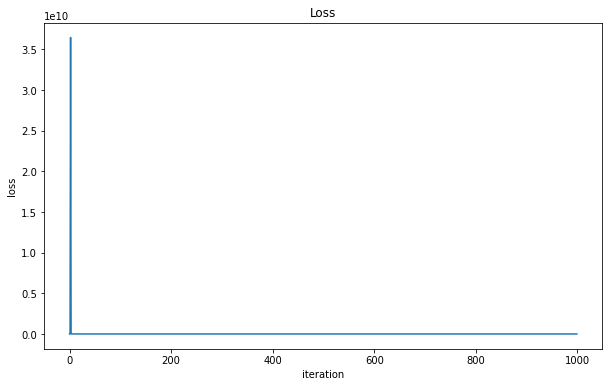

In [33]:
# Plotting
plt.figure(figsize = (10,6)) 
plt.plot(loss_list, label = 'loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss')


plt.show()
